In [2]:
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
import random
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop, RandomCrop
from autocodec.codec import AutoCodecND, pil_to_latent, latent_to_pil

In [3]:
dataset = datasets.load_dataset("danjacobellis/nuscenes_front").cast_column('video', datasets.Video()).with_format("torch")

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/115 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/115 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/74 [00:00<?, ?it/s]

In [4]:
device = "cuda"
config = SimpleNamespace()
config.F = 8
config.latent_dim = 24
config.input_channels = 3
config.lightweight_encode = True
config.lightweight_decode = False
config.post_filter = 4
config.encoder_depth = 6
config.λ = 3e-2
config.ema_decay = 0.999
config.consistency_start = 0.05
config.consistency_loss = 0.1
config.max_lr = 1e-3
config.min_lr = config.max_lr / 1e3
config.lr_pow = 6
config.n_frames=32
config.progressive_sizes = [8*int(s) for s in np.linspace(2,2.75,10)**3]; print(config.progressive_sizes)
config.batch_size = 4
config.num_workers = 20
config.epochs = 300
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = None

[64, 72, 80, 88, 96, 112, 120, 136, 144, 160]


In [5]:
model = AutoCodecND(
    dim=3,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
    post_filter = config.post_filter
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

275.498072 M parameters


In [6]:
import copy
class EMAHelper:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.teacher = copy.deepcopy(model)
        for p in self.teacher.parameters():
            p.requires_grad_(False)

    @torch.no_grad()
    def update(self, student):
        for ema_p, student_p in zip(self.teacher.parameters(), student.parameters()):
            ema_p.copy_(ema_p * self.decay + student_p * (1 - self.decay))

In [7]:
def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]
    
def collate_fn(batch,epoch):
    n_frames = config.n_frames
    h = get_epoch_size(epoch)
    w = get_epoch_size(epoch)
    batch_tensors = []
    for sample in batch:
        video = sample['video']
        len_video = len(video)
        start = random.randint(0, len_video - n_frames)
        indices = range(start, start + n_frames)
        frames = video.get_batch(indices)
        H, W = frames.shape[1], frames.shape[2]
        i = random.randint(0, H - h)
        j = random.randint(0, W - w)
        frames_cropped = frames[:, i:i+h, j:j+w, :]
        frames_cropped = frames_cropped.permute(3, 0, 1, 2)
        batch_tensors.append(frames_cropped)
    return torch.stack(batch_tensors, dim=0).to(torch.float)/127.5 - 1.0

In [8]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []
consistency_losses = []

ema_helper = EMAHelper(model, decay=config.ema_decay)

global_step = 0
model.train()
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)

        # Main model forward pass (additive noise)
        z = model.encode(x)
        z_noisy = model.quantize(z)
        x_hat = model.decode(z_noisy)

        # Reconstruction and rate loss
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate = model.quantize.compand(z).std().log2()
        rate_losses.append(rate.item())

        total_loss = mse_loss + config.λ * rate

        # EMA Latent Consistency Loss
        if global_step > config.consistency_start * config.total_steps:
            with torch.no_grad():
                z_teacher = ema_helper.teacher.encode(x)
                z_teacher = ema_helper.teacher.quantize.compand(z_teacher).round()
            consistency_loss = torch.nn.functional.mse_loss(
                model.quantize.compand(z), z_teacher
            ).log10()
            consistency_losses.append(consistency_loss.item())
            total_loss += config.consistency_loss * consistency_loss
            pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, "
                          f"Consistency: {consistency_loss:.4f}, LR: {learning_rates[-1]:.2g}")
        else:
            pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, "
                          f"LR: {learning_rates[-1]:.2g}")

        # Backpropagation and optimizer step
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # EMA update step after optimizer step
        ema_helper.update(model)

        global_step += 1


KeyboardInterrupt



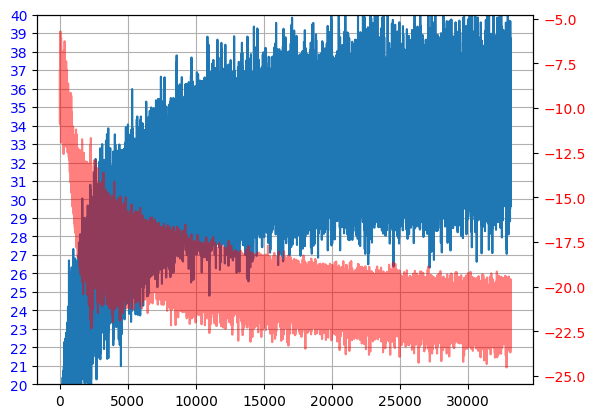

In [11]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.set_yticks(range(20,41))
ax1.set_ylim([20,40])
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

In [12]:
torch.save({
    'config': config,
    'state_dict': model.state_dict()
}, '../hf/dance/LF_nuscenes_f8c96_v1.1.pth')

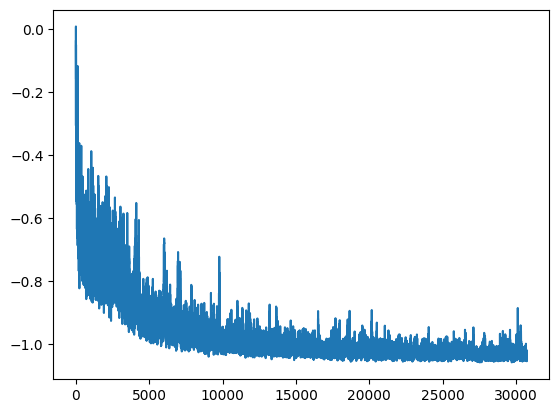

In [13]:
plt.plot(consistency_losses)

In [14]:
from IPython.display import display, clear_output
from ipywidgets import interact

model.eval()
config.n_frames=256
def get_epoch_size(epoch):
    return 256
x = collate_fn(dataset['validation'].select([1]),0).to(device)
orig_dim = x.numel()

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()
latent = einops.rearrange(latent, 'b c d h w -> b (c d) h w').cpu()

webp = latent_to_pil(latent, n_bits=8, C=3)
# display(webp[0])
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())

print(f"Compressed size: {size_bytes / 1e3:.2f} KB")
print(f"Compression ratio: {orig_dim / size_bytes:.2f}x")
print(f"Dimension reduction: {orig_dim / latent.numel():.2f}x")

latent_decoded = pil_to_latent(webp, N=latent.shape[1], n_bits=8, C=3)
latent_decoded = einops.rearrange(latent_decoded, 'b (c d) h w -> b c d h w', d=32).to(device)

with torch.no_grad():
    x_hat = model.decode(latent_decoded).clamp(-1, 1)

mse = torch.nn.functional.mse_loss(x, x_hat)
PSNR = -10 * mse.log10().item() + 6.02

print(f"PSNR: {PSNR:.2f} dB")

original_volume = x[0].cpu().numpy()
reconstructed_volume = x_hat[0].cpu().numpy()

def show_slices(slice_idx):
    clear_output(wait=True)
    orig_slice = ToPILImage()(einops.rearrange(original_volume[:,slice_idx],'c h w -> h w c')/2+0.5)
    recon_slice = ToPILImage()(einops.rearrange(reconstructed_volume[:,slice_idx],'c h w -> h w c')/2+0.5)
    display(orig_slice)
    display(recon_slice)

interact(show_slices, slice_idx=(0, original_volume.shape[1]-1, 1));

Compressed size: 345.34 KB
Compression ratio: 145.75x
Dimension reduction: 64.00x
PSNR: 30.60 dB


interactive(children=(IntSlider(value=127, description='slice_idx', max=255), Output()), _dom_classes=('widget…

In [15]:
print(f"Compressed size: {size_bytes / 1e3:.2f} KB")
print(f"Compression ratio: {orig_dim / size_bytes:.2f}x")
print(f"Dimension reduction: {orig_dim / latent.numel():.2f}x")
print(f"PSNR: {PSNR:.2f} dB")

Compressed size: 345.34 KB
Compression ratio: 145.75x
Dimension reduction: 64.00x
PSNR: 30.60 dB


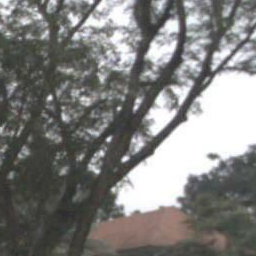

In [16]:
ToPILImage()(einops.rearrange(original_volume[:,122],'c h w -> h w c')/2+0.5)

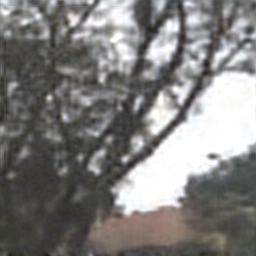

In [17]:
ToPILImage()(einops.rearrange(reconstructed_volume[:,122],'c h w -> h w c')/2+0.5)

bpc: 4.282860065576432, cr: 119.54628266172169


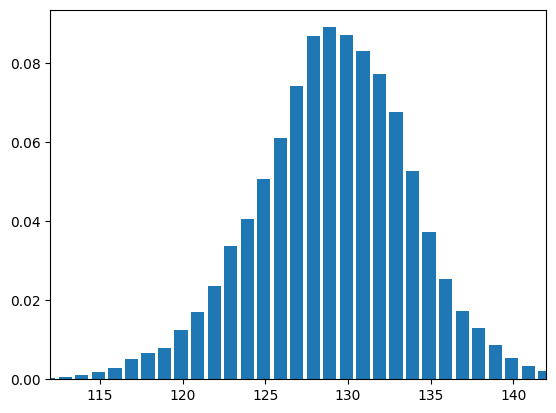

In [19]:
from torch.distributions import Categorical
x_int8 = torch.tensor(np.array(webp[0]))
h = plt.hist(x_int8.flatten(),range=(-0.5,255.5),bins=256,width=0.8,density=True)
bpc = np.log2(np.exp(1))*Categorical(torch.tensor(h[0])).entropy()
plt.xlim([127-15,127+15])
print(f"bpc: {bpc.item()}, cr: {orig_dim/latent.numel()*(8/bpc.item())}")